# Hypercolumns for Semantic Segmentation

The importance of semantic segmentation comes from the necessity of understanding the context in a scene. This is very useful for different applications that involve handling scenes in real life in real-time. The task of semantic segmentation can be defined as a fine-grained inference by making dense predictions to infer labels for each pixel and return labeled regions. If done correctly, one can delineate the contours of all the objects appearing on the input image. As a result of classifying
each pixel, the task is more challenging.

In their paper "Hypercolumns for Object Segmentation and Fine-grained Localization," B. Hariharan et al. had the idea of representing pixels by a set of features along different layers, shallow and deep ones, of the CNN. In this way, they take advantage of the precise localization of features present on earlier layers and the semantics that shallow layers provide. They defined the hypercolumn at a pixel as the vector of activations of all CNN units above that pixel.

In the original paper, the authors used the hypercolumn representation to perform semantic segmentation and keypoint predictions for joints localization. The purpose of this project is to understand and implement this approach. Moreover, it will be applied to a different CNN called **SqueezeNet** to observe its performance.

In [ ]:
# Import packages needed for the project

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils import data
import torch.optim as optim
import os.path
from PIL import Image
import random
from matplotlib import pyplot as plt

import collections
import numpy as np
import PIL
import imageio
import cv2
from google.colab.patches import cv2_imshow
import pdb
#/content/gdrive/MyDrive/Third semester/courses/Adv_vision/Project/code/data/VOCdevkit/VOC2012/JPEGImages
#root_dir='/content/gdrive/MyDrive/Third semester/courses/Adv_vision/Project/code'
root_dir='/'
cnn = 'sqn'

### Dataset

For this project the PASCAL Visual Object Classes 2012 was used. It was thought as a dataset to help generate pixel-wise segmentations giving the class of the object visible at each pixel, or "background" otherwise. It has 21 classes including background. It has 1465 training examples and 1450 test examples.

For the project, the dataset is mounted in Google Drive folders. Therefore, Drive should be mounted so that Colab can access the files.

In [ ]:
#from google.colab import drive

#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Uncomment to uncompress the dataset of VOC

#!tar -xvf '/content/drive/MyDrive/Third semester/courses/Adv_vision/Project/VOCtrainval_11-May-2012.tar' -C '/content/drive/MyDrive/Third semester/courses/Adv_vision/Project/code/data'

In [ ]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

The first step is to obtain the dataset and create the class to load the data. 

In [ ]:
class PascalVOC(data.Dataset):
    def __init__(self,root=root_dir+'/data/VOCdevkit/VOC2012', split="train", img_transform=None, label_transform=None): #'./data/VOCdevkit/VOC2012'
        self.root = root
        self.split = split
        #self.n_classes = 21
        self.img_transform = img_transform
        self.label_transform = label_transform
        self.im_height = 224
        self.im_width = 224
        #self.mean_pixel = np.array([103.939, 116.779, 123.68]) # Se puede comentar?

        #pdb.set_trace()
        #load name of images(files) into self.files
        self.files = collections.defaultdict(list)
        for split in ["train", "val"]:
            file_list = tuple(open(root + '/ImageSets/Segmentation/' + split + '.txt', 'r')) # open txt with name of images for training/val
            file_list = [id_.rstrip() for id_ in file_list] # Create list of paths for each image
            self.files[split] = file_list

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # Get each images and corresponding label
        img_name = self.files[self.split][index]
        img_path = self.root + '/JPEGImages/' + img_name + '.jpg'
        label_path = self.root + '/SegmentationClass/' + img_name + '.png'

        # Open image as RGB (3 channels) and in Pallete (1 channel). Labels are masks with the segmented region colored (value given by the Pallete) and black background
        pil_img = Image.open(img_path).convert('RGB')
        pil_lbl = Image.open(label_path).convert("P")

        #Resize images to self.im_height, self.im_width
        pil_img = pil_img.resize((self.im_height, self.im_width), PIL.Image.BILINEAR)
        pil_lbl = pil_lbl.resize((self.im_height, self.im_width), PIL.Image.NEAREST)

        img = np.array(pil_img)
        lbl = np.array(pil_lbl)
        lbl[lbl==255] = 0 # Set region's white boarders to black 

        pil_img = 0
        pil_lbl = 0

        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)

        return torch.from_numpy(img), torch.from_numpy(lbl).long()

## Creation and training of the classifier

As the semantic segmentation task implies classifying each pixel into a class, a classifier has to be created. For computing efficiency, this classifier will be pre-trained alone and then fine-tuned when training the whole model. Hence, after loading the dataset, the next step is to train the classifier which will classify each pixel into one of the 21 classes. To do so, this classifier has to be trained with hypercolumns as training examples. This hypercolumns are extracted from the training set. **The first step in this process is to define hypercolumns.**

### Hypercolumns class

As stated before, an hypercolumn at a given input location is defined  as
the outputs of all units above that location at all (or some) layers of
the CNN, stacked into one vector. Therefore, a CNN has to be defined to obtain the features from each layer. In this project, the initial CNN will be the well defined VGG-11. This CNN can be downloaded from PyTorch directly along with its trained parameters. The second CNN that will be tested will be the SqueezeNet. As it is composed of Fire blocks, the extraction process is different. 
Both CNNs will be defined in a Hypercolumn class which will create the hypercolumns when forward feeded.

In [ ]:
'''
Example of VGG-11 net:
      [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
       Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
       Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
       Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
       Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       ReLU(inplace=True),
       MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
'''

class Hypercolumn(nn.Module):
    def __init__(self, net):
        super(Hypercolumn, self).__init__()

        if net == 'vgg':
            print('using VGG-11')
            self.net = models.vgg11(pretrained=True)

          # features contains features (layers: conv, relu, maxpool), avgpool, and the classifier (linear, relu, dropout). 
          # Children returns only features (21 layers: conv, relu, maxpool)
            self.feature_list = list(self.net.features.children())

          #Index of conv2d layers from which hyperplane features will be taken
            self.index_layers_to_extract = [0,3,8,13,18]

        elif net == 'sqn':
            print('using SqueezeNet')
            #fire block structure ['squeeze', 'squeeze_activation', 'expand1x1', 'expand1x1_activation', 'expand3x3', 'expand3x3_activation']
            # load the pre-trained CNN
            self.net = models.squeezenet1_0(pretrained=True)
            self.feature_list = list(self.net.features.children())
            self.index_layers_to_extract = [0,3,4,7,9,12]

    def forward(self, x):

        layer_output = x

        activations = []

        #Loop over all the layers of the net
        for index, layer in enumerate(self.feature_list):

            # If the layer is a Fire block (from squeeze net)
            if type(layer).__name__ == 'Fire':

                layer_output = layer.squeeze_activation(layer.squeeze(layer_output))
                expand1x1 = layer.expand1x1(layer_output)
                expand3x3 = layer.expand3x3(layer_output)

                if (index in self.index_layers_to_extract):

                    # Upsample the features
                    upsampled_layer_output = F.interpolate(torch.cat([expand1x1,expand3x3], 1), size=224, mode='bilinear', align_corners=True)
                    activations.append(upsampled_layer_output) # activations have the features from each layer after upsampling

                layer_output = torch.cat([layer.expand1x1_activation(expand1x1),layer.expand3x3_activation(expand3x3)], 1)

            else:
                #Apply layer
                layer_output = layer(layer_output)

                #In the case of a conv2d layer, save activation
                if (index in self.index_layers_to_extract):
                    # Upsample the features
                    upsampled_layer_output = F.interpolate(layer_output, size=224, mode='bilinear', align_corners=True)
                    activations.append(upsampled_layer_output) # activations have the features from each layer after upsampling

        # Finally, layers are combined into the sum of all channels of the layers in activation
        #VGG: 1472 = 64+128+256+512+512. Shape: [1, 1472, 224, 224]
        #SqueezeNet: 1504= 96+128+128+256+384+512
        output = torch.cat(activations, dim = 1)
        return output



### Pixel classifier

Before obtaining the samples of hypercolumns to train the pixel classifier, it has to be defined. This classifier is a fully connected network with two layers. It recieves as input the extracted hypercolums and outputs a matrix of shape [H x W x 21] probabilities.

In [ ]:
class FCClassifier(nn.Module):

    def __init__(self, net, n_classes=21):
        super(FCClassifier, self).__init__()

        #Save means and stds
        features = np.load(root_dir+"/hypercolumn_samples/pre-trained/"+net+"/feats_x.npy")        
        means = np.mean(features, axis=0)
        stds = np.std(features, axis=0)

        np.save(root_dir+"/hypercolumn_samples/mean.npy", means)
        np.save(root_dir+"/hypercolumn_samples/std.npy", stds)  

        self.mean = torch.Tensor(means)
        self.std = torch.Tensor(stds)

        # Fully coneccted clasifier with two layers
        if net == 'vgg':
            self.fc1 = nn.Linear(1472,512)
            self.fc2 = nn.Linear(512,21)
        elif net=='sqn':
            self.fc1 = nn.Linear(1504,512)
            self.fc2 = nn.Linear(512,21)

    def forward(self, x):
        # batch normalization
        x = (x - self.mean)/(self.std+ 1e-5)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        #probs = F.log_softmax(x, dim=0)

        return x

Once the Hypercolumn class has been defined, the next step is to extract the hypercolum examples to train the classifier. To do so, the function 'extract_samples' will receive a hypercolumn object the dataset and the selected network. It will return a subsample of hypercolumns. In order to be efficient, it will sample 3 pixels per image from each class.

In [ ]:
def extract_samples(hypercolumn, dataset, net):

    samples_features = []
    samples_labels = []
    net_dim = 1472  if net=='vgg' else 1504
    #print(net_dim)

    for image_idx in range(len(dataset)):
        # Get image(3 channels) and labels (1 channel)
        images, labels = dataset[image_idx]
        
        #Get hypercolumn features
        with torch.no_grad():
            features = hypercolumn.forward(images.cpu().float().unsqueeze(0)) # Hypercolumn features are of size [1, 1472, 224, 224]

        #Total different classes in this image
        classes = labels.unique()

        #Sample 3 pixels per image from each class
        for c in classes:

            #Indices of pixels with class c
            pixels_indices_for_c = np.argwhere(labels.numpy()==c.numpy())

            #Get 3 random pixels
            for i in range(0,3):   
                random_index = random.randint(0,len(pixels_indices_for_c)-1)
                y, x = pixels_indices_for_c[random_index]                

                random_feature = features[0,range(net_dim),y,x]
                random_label = labels[y,x]

                samples_features.append(random_feature.detach().clone().numpy())
                samples_labels.append(random_label.detach().clone().numpy())

    return np.asarray(samples_features), np.asarray(samples_labels)

hypercolumn = Hypercolumn(net=cnn).cpu().float()

# Backpropagation is not necessary
for param in hypercolumn.parameters():
    param.requires_grad = False

dataset_train = PascalVOC(split = 'train')

features, labels = extract_samples(hypercolumn, dataset_train, net=cnn)
#print(features)

np.save(root_dir+"/hypercolumn_samples/feats_x.npy", features)
np.save(root_dir+"/hypercolumn_samples/feats_y.npy", labels)
#49 mins

### Pre-train the classifier

Having the classifier defined and the hypercolumns as training examples, the next step is to pre-train the classifier. To do so, the features saved in the previous step will be used. It receives a hypercolumn and outputs a label. This is denominated a sparse training because it uses only some hypercolumns to pre train the classifier.

In [ ]:
# As it is a sparse training, the softmax results are very similar (same probability for all classes: [tensor([0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476]).

def cross_entropy1d(predictions, targets):

    #logsoftmax = nn.LogSoftmax(dim=1)
    #loss = nn.NLLLoss()
    #pred = logsoftmax(predictions)
    #print('softmax, shape', list(pred[0:10]), pred.shape)
    #print('labels, shape', list(targets.unique()), targets.shape)
    loss = nn.CrossEntropyLoss()
    output = loss(predictions, targets)
    #output = loss(pred,targets)  

    return output

def train(dataset, model, optimizer, epoch):

    for epoch in range(num_epochs):

        data_x, data_y = dataset

        tensor_x = torch.tensor(data_x, dtype=torch.long)
        tensor_y = torch.tensor(data_y, dtype=torch.long)

        model.train() #Set model in traininig mode

        #print("Epoch: "+str(epoch))

        # Zero out all of the gradients for the variables which the optimizer will update.
        optimizer.zero_grad()

        #Forward
        predictions = model.forward(tensor_x)
        #print('pred, shape', predictions[0], predictions.shape)

        #Loss
        #loss = cross_entropy1d(predictions, tensor_y)
        loss = nn.CrossEntropyLoss()
        output = loss(predictions, tensor_y)

        #Backwards pass
        #loss.backward()
        output.backward()

        #Update parameters of model
        optimizer.step()

        torch.save(model, root_dir+"/models/fc_cls.pkl")


net = cnn
classifier = FCClassifier(net).float()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)# pick an optimizer.
dataset_x = np.load(root_dir+"/hypercolumn_samples/pre-trained/"+net+"/feats_x.npy")
dataset_y = np.load(root_dir+"/hypercolumn_samples/pre-trained/"+net+"/feats_y.npy")
num_epochs = 20

train([dataset_x, dataset_y], classifier, optimizer, num_epochs)


This fully connected classifier receives an hypercolumn (one dimension vector) and classifies it into one of the 21 classes. The fully connected layers can be transformed to 1x1 convolutions. This enhances performance because  It allows us to “slide” the original weights very efficiently across many spatial positions in a larger image, in a single forward pass. Therefore, the **fully connected classifier is converted into a Dense classifier of 1x1 convolution.**

In [ ]:
class DenseClassifier(nn.Module):

    def __init__(self, fc_model, n_classes=21):
        super(DenseClassifier, self).__init__()

        self.mean = torch.Tensor(np.load(root_dir+"/hypercolumn_samples/mean.npy")) # It has shape [1472]
        self.std = torch.Tensor(np.load(root_dir+"/hypercolumn_samples/std.npy")) # It has shape [1472]

        # Add these trailing dimensions so that it broadcasts correctly.
        self.mean = torch.Tensor(np.expand_dims(np.expand_dims(self.mean, -1), -1)) # Expands to an array of shape (len(mean), 1, 1)
        self.std = torch.Tensor(np.expand_dims(np.expand_dims(self.std, -1), -1))  

        self.mean = self.mean.to(device=device)
        self.std = self.std.to(device=device)      
        
        #Convert a fully connected classifier to 1x1 convolutional. fc_model.children has two fully connected layers (linear)    
        # (fc1): Linear(in_features=1472, out_features=512, bias=True), (fc2): Linear(in_features=512, out_features=21, bias=True) 
        # It will transfer weights and bias from fc layers to the conv 1x1 layers       
        for index, fc_layer in enumerate(fc_model.children()):

            fc_layer_params = fc_layer.state_dict() # get dictionary that maps the layer to its parameter tensor. Get weight as key and the values (weights-params) as value
            dim_out, dim_in = fc_layer_params["weight"].shape # Shape of the weights: [512, 1472] and [21, 512]
            
            #Declare the convolution layer
            convolution = nn.Conv2d(dim_in, dim_out, 1,1) # Creates the 1x1 conv layer with same dims as weigths of fc layer

            #Load the weights into the new conv layer
            convolution.load_state_dict(
                {"weight":fc_layer_params["weight"].view(dim_out, dim_in, 1,1),"bias":fc_layer_params["bias"]})

            #Set the convolution layers to dense classifier (this class)
            setattr(self, "conv"+str(index+1), convolution)

    def forward(self, x): #x.shape = (n,1472,224,224)

        # batch normalization
        x = (x - self.mean)/(self.std+ 1e-5)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
    
        return x

### Complete training of the classifier

The last step is to train the pixel wise classifier with all the hypercolumns for each image. However, some functions are implemented before training and validation steps. 

The function *'visualize'* is in charge of creating the predicted image and the ground truth masks image. So, it receives the predicted labels and color the pixels by taking into account the predictions and the pascal labels (contains the predefined color for each class).

In [ ]:
pascal_labels = np.asarray([[0,0,0], [128,0,0], [0,128,0], [128,128,0], [0,0,128], [128,0,128],
        [0,128,128], [128,128,128], [64,0,0], [192,0,0], [64,128,0], [192,128,0],
        [64,0,128], [192,0,128], [64,128,128], [192,128,128], [0, 64,0], [128, 64, 0],
        [0,192,0], [128,192,0], [0,64,128]])

def visualize(predicted_label):
    #Apparently it outputs the images with the predicted label from the list pascal_labels
    label = predicted_label

    # Create image of 3 channels
    label_viz = np.zeros((label.shape[0], label.shape[1], 3))

    # Get classes labels present in predicted_label
    for unique_class in np.unique(label):
        if unique_class != 0: # For classes other than backgorund
            indices = np.argwhere(label==unique_class) # obtain indices where the pixel belongs to class unique_class
            for idx in range(indices.shape[0]):
                # Color each of these indexes with the predefined color for each class (present in pascal_labels)
                label_viz[indices[idx, 0], indices[idx, 1], :] = pascal_labels[unique_class,:] 

    return label_viz
    #cv2.imwrite(path, label_viz)
    #root_dir+"/images/masks.jpg"
    #imageio.imwrite(path, label_viz)

This is a function to compute label accuracy score

In [ ]:
# Originally written by wkentaro
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/utils.py

#import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class**2).reshape(n_class, n_class)
    return hist

def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc


Finally, the general process to train and test the complete models is defined. These training process takes into account all pixels from all images.

In [ ]:
def cross_entropy2d(predicts, targets):

    unique_targets, counts = torch.unique(targets, return_counts=True)

    logsoftmax = nn.LogSoftmax(dim=1)

    #weight (Tensor, optional) – a manual rescaling weight given to each class. If given, it has to be a Tensor of size C. Otherwise, it is treated as if having all ones.
    weights = torch.zeros([21], dtype=torch.float64)
    for i in range(len(unique_targets)):
        weights[unique_targets[i]] = 1/counts[i].float()

    weights = weights.to(device=device)
    loss = nn.NLLLoss(weight=weights.float())
    output = loss(logsoftmax(predicts),targets)  

    return output


def train(args, hypercolumn, model, train_loader, optimizer, epoch):
    count = 0
    model = model.to(device=device)
    losses = []

    #model.train() tells the model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. 
    model.train()

    for batch_idx, (images, labels) in enumerate(train_loader):

        if(USE_GPU and torch.cuda.is_available()):
            images = images.cuda(device)
            labels = labels.cuda(device)

        #Generate tensor of features (hypercolumns) of every image
        images_features = []
        for image in images:
            with torch.no_grad():
                if not (USE_GPU and torch.cuda.is_available()):
                    image = image.cpu()
                z = hypercolumn.forward(image.float().unsqueeze(0))# # Obtain hypercolumns for each pixel of image
            images_features.append(z)       
        
        # features contains the hypercolumns, a tensor of shape [2, 1472, 224, 224]. Each pixel is an hypercolumn: 
        # [#images in batch, # length of hypercolumn, heigh, width]
        features = torch.cat(images_features, dim = 0)

        features = features.to(device=device)

        model.train() #Set model in train mode

        optimizer.zero_grad() #zero out all of the gradients 

        # predictions is a tensor of shape [2, 21, 224, 224], so each pixel has a score for each class from the 21 classes
        predicts = model.forward(features)

        # labels is a tensor of shape [2, 224, 224]. It contains a label per each pixel
        loss = cross_entropy2d(predicts, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.data.item())

        if batch_idx % 100 == 0:
            count = count + 1
            print("Epoch [%d/%d] Loss: %.4f" % (epoch+1, args['n_epoch'], loss.data.item()))

        if batch_idx % 100 == 0:
            """
            Visualization of results.
            """
            #Take the first image of this batch to be visualized
            pred = predicts[0,:,:,:] # predicts is shape [2, 21, 224, 224]
            gt = labels[0,:,:].data.cpu().numpy().squeeze()
            im = images[0,:,:,:].data.cpu().numpy().squeeze()
            im = np.swapaxes(im, 0, 2)
            im = np.swapaxes(im, 0, 1)
            _, pred_mx = torch.max(pred, 0) # Get index of maximum value for each pixel which is the class for each pixel
            pred = pred_mx.data.cpu().numpy().squeeze()
            image = Image.fromarray(im.astype(np.uint8), mode='RGB')

            #cv2.imwrite(root_dir+"/images/imgs/" + str(count) + "_" + str(epoch) + "_.png", image)
            image.save(root_dir+"/images/imgs/" + str(count) + "_" + str(epoch) + "_.png")
            cv2.imwrite(root_dir+"/images/masks/pred_" + str(count) + "_" + str(epoch) + ".png", visualize(pred))
            cv2.imwrite(root_dir+"/images/masks/gt_" + str(count) + "_" + str(epoch) + ".png", visualize(gt))

    # Save your model periodically
    torch.save(model, root_dir+"/models/full_model.pkl")
    return np.average(losses)

def val(args, hypercolumn, model, val_loader):

    # modified from https://github.com/wkentaro/pytorch-fcn/blob/master/examples/voc/evaluate.py
    model = model.to(device=device)

    model.eval()
    print("Validating...")
    label_trues, label_preds = [], []

    # For each image in validation set, get prediction and pair each pixel to its ground truth label. The pairs for all images
    # will be saved in label_trues, label_preds
    for batch_idx, (data, target) in enumerate(val_loader):

        # Each data and target correspond to one image from validation set 
        data, target = data.float(), target.float()
        #print(data.shape)
        #print(target.shape)

        data = data.to(device=device)
        target = target.to(device=device)

        score = model.forward(hypercolumn(data))

        _, pred = torch.max(score, 1)#0
        lbl_pred = pred.data.cpu().numpy().astype(np.int64)
        lbl_true = target.data.cpu().numpy().astype(np.int64)

        for _, lt, lp in zip(_, lbl_true, lbl_pred):
            label_trues.append(lt)
            label_preds.append(lp)

    n_class = 21
    metrics = label_accuracy_score(label_trues, label_preds, n_class=n_class)
    metrics = np.array(metrics)
    metrics *= 100
    print('''\
    Accuracy: {0}
    Accuracy Class: {1}
    Mean IU: {2}
    FWAV Accuracy: {3}'''.format(*metrics))
    #accuracies.append(metrics[0])
    #iou.append(metrics[2])

    return metrics


USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)


using device: cuda


The following cell runs the training and validating  processes defined before. The net variable can take two values: 'vgg' and 'sqn' to define the CNN to use, VGG-11 or SqueezeNet. 

In [ ]:
net = cnn
args = {'batch_size': 2, 'l_rate':0.001, 'model_path':root_dir+"/models/trained/"+net+"/fc_cls.pkl", 'n_epoch':10}

hypercolumn = Hypercolumn(net).float() # Create class for hypercolumns, downloads and load model VGG into zoomout, extracts layers of interest
hypercolumn = hypercolumn.to(device=device)


# we will not train the feature extractor
for param in hypercolumn.parameters():
    param.requires_grad = False

# load classifier in /models. This classifier is a fc that classifies hypercolumns (saved in feats_x.npy). It has 2 fc layers.
fc_classifier = torch.load(args['model_path']) 
fc_classifier = fc_classifier.to(device=device)

# take fc classifier and convert it in a dense classifier. It converts the fully connected classifier to 1x1 convolutional.
# This is the classifier that is trained with all of the hypercolumns to classify pixels (semantic segmentation)
classifier = DenseClassifier(fc_model=fc_classifier).float() 
classifier = classifier.to(device=device)

optimizer = optim.Adam(classifier.parameters(), lr=args['l_rate'])# Start in range [1e-3, 1e-4].

# It loads images paths into lists and define methods to get item, get len
# It defines it as a map-style dataset which implements the __getitem__() and __len__() protocols
dataset_train = PascalVOC(split = 'train')
dataset_val = PascalVOC(split = 'val')

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args['batch_size'], shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=4)


using VGG-11


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The next blocks will deploy the figures for loss, accuracy and intersection over union so that we can see the performance of each model.

In [ ]:
#metrics = np.array(args['n_epoch'])
metrics = []
losses = []
for epoch in range(args['n_epoch']):
    print(epoch)
    loss = train(args, hypercolumn, classifier, train_loader, optimizer, epoch)
    losses.append(loss)
    metrics.append(val(args, hypercolumn, classifier, val_loader))

#print(metrics)
#print(losses)

0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/10] Loss: 2.3134
Epoch [1/10] Loss: 1.8198
Epoch [1/10] Loss: 2.2999
Epoch [1/10] Loss: 2.6376
Epoch [1/10] Loss: 2.7231
Epoch [1/10] Loss: 2.5570
Epoch [1/10] Loss: 2.0312
Epoch [1/10] Loss: 2.3903
Validating...
    Accuracy: 67.72866205229504
    Accuracy Class: 16.223226345570193
    Mean IU: 8.986053682517682
    FWAV Accuracy: 56.91782554818793
1
Epoch [2/10] Loss: 3.0097
Epoch [2/10] Loss: 1.6236
Epoch [2/10] Loss: 2.1389
Epoch [2/10] Loss: 2.9321
Epoch [2/10] Loss: 2.1172
Epoch [2/10] Loss: 2.3954
Epoch [2/10] Loss: 3.2899
Epoch [2/10] Loss: 1.8438
Validating...
    Accuracy: 64.35226401960887
    Accuracy Class: 18.947803573397785
    Mean IU: 10.361796846455595
    FWAV Accuracy: 54.76343921393146
2
Epoch [3/10] Loss: 1.8119


No handles with labels found to put in legend.


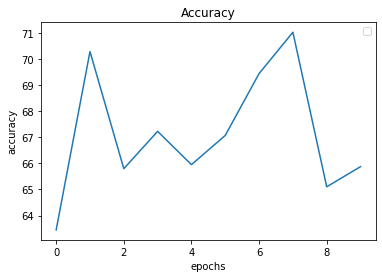

No handles with labels found to put in legend.


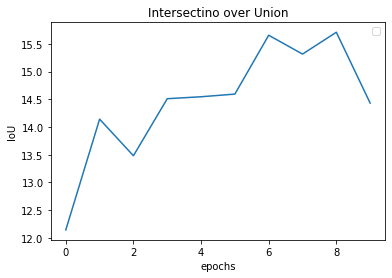

No handles with labels found to put in legend.


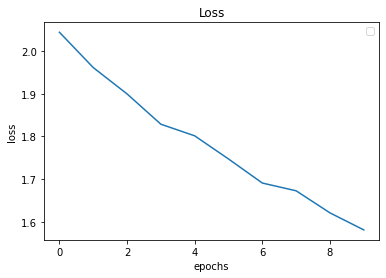

No handles with labels found to put in legend.


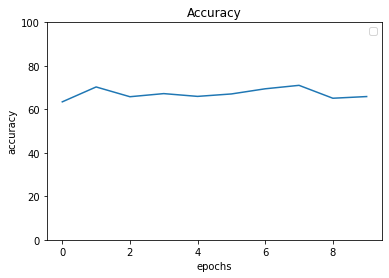

In [ ]:
def plot_curve(x, y, x_name, y_name, title):
    plt.plot(x,y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)
    plt.legend()
    plt.show()

m = np.array(metrics)
acc = np.array(metrics)[:,0]
iou = np.array(metrics)[:,2]

plot_curve(range(acc.shape[0]), acc, "epochs", "accuracy", "Accuracy")
plot_curve(range(iou.shape[0]), iou, "epochs", "IoU", "Intersectino over Union")
plot_curve(range(len(losses)), losses, "epochs", "loss", "Loss")

plt.ylim([0, 100])
plot_curve(range(acc.shape[0]), acc, "epochs", "accuracy", "Accuracy")

## Unit testing of the model

Finally, a function to load the full trained model and test it on a single image is defined. It allows to run the model and display  the image and predicted mask. It presents the qualitative results.

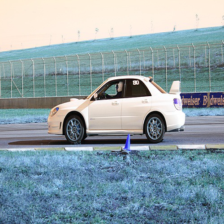

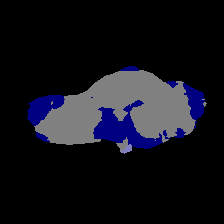

In [ ]:
def get_image(img_name, gt=False): 
    returned_imgs = []    
    # Get each images and corresponding label
    img_path = root_dir + '/images/test/' + img_name + '.jpg'
    pil_img = Image.open(img_path).convert('RGB')
    pil_img = pil_img.resize((224, 224), PIL.Image.BILINEAR)
    img = np.array(pil_img)
    pil_img = 0    
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    returned_imgs.append(torch.from_numpy(img))
    
    if gt:
        label_path = root_dir + '/images/test/' + img_name + 'gt.png'
        pil_lbl = Image.open(label_path).convert("P")
        pil_lbl = pil_lbl.resize((224, 224), PIL.Image.NEAREST)
        lbl = np.array(pil_lbl)
        lbl[lbl==255] = 0 # Set region's white boarders to black
        pil_lbl = 0  
returned_imgs.append(torch.from_numpy(lbl).long())              

    return returned_imgs

def run_model(img_name, gt=False):
    net = 'sqn'
    image = get_image(img_name, gt)
    model = torch.load(root_dir+"/models/trained/"+net+"/full_model.pkl")

    model.eval()

    with torch.no_grad():

        data = image[0].float()
        data = torch.Tensor(np.expand_dims(data, 0))

        data = data.to(device=device)

        score = model.forward(hypercolumn(data))

        #Take the first image of this batch to be visualized
        im = data.data.cpu().numpy().squeeze()
        im = np.swapaxes(im, 0, 2)
        im = np.swapaxes(im, 0, 1)
        _, pred_mx = torch.max(score, 1)#
        pred = pred_mx.data.cpu().numpy().squeeze()
        #img = Image.fromarray(im.astype(np.uint8), mode='RGB')
        pred = visualize(pred)
        cv2_imshow(im)
        cv2_imshow(pred)

        if len(image)==2:
            target = image[1].float()
            target = target.to(device=device)
            gt = target.data.cpu().numpy().squeeze()
            cv2_imshow(pred.numpy())
            lbl_pred = pred.data.cpu().numpy().astype(np.int64)
            lbl_true = target.data.cpu().numpy().astype(np.int64)

            for _, lt, lp in zip(_, lbl_true, lbl_pred):
                label_trues.append(lt)
                label_preds.append(lp)

            n_class = 21
            metrics = label_accuracy_score(label_trues, label_preds, n_class=n_class)
            metrics = np.array(metrics)
            metrics *= 100
            print('''\
            Accuracy: {0}
            Accuracy Class: {1}
            Mean IU: {2}
            FWAV Accuracy: {3}'''.format(*metrics))

run_model("2007_004830")

### References

https://blog.christianperone.com/2016/01/convolutional-hypercolumns-in-python/

https://github.com/xksteven/Sparse-Hypercolumns

https://github.com/fhalamos/semantic-segmentation-with-cnn

https://github.com/BerenLuthien/HyperColumns_ImageColorization
